<h1>Heartbeat Analysis With Machine Learning</h1>
Author: Syed Mahdi

In [1]:
import os
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import wave

<h2>Exploring Our Dataset</h2>

In [2]:
path = "./heartbeat_dataset"  # Path to our dataset

In [3]:
set_a = pd.read_csv(path + "/set_a.csv")
print(f"Unique labels: {set_a['label'].unique()}")
set_a

Unique labels: ['artifact' 'extrahls' 'murmur' 'normal' nan]


,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
171,a,set_a/__201108222241.wav,NaN,NaN
172,a,set_a/__201108222244.wav,NaN,NaN
173,a,set_a/__201108222247.wav,NaN,NaN
174,a,set_a/__201108222254.wav,NaN,NaN


In [4]:
set_a_timing = pd.read_csv(path + "/set_a_timing.csv")
set_a_timing

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992
...,...,...,...,...
385,set_a/normal__201108011118.wav,10,S2,284673
386,set_a/normal__201108011118.wav,11,S1,300863
387,set_a/normal__201108011118.wav,11,S2,314279
388,set_a/normal__201108011118.wav,12,S1,330980


In [5]:
set_b = pd.read_csv(path + "/set_b.csv")
print(f"Unique labels: {set_b['label'].unique()}")
set_b

Unique labels: ['extrastole' 'murmur' 'normal' nan]


,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN
...,...,...,...,...
651,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
652,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
653,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
654,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


In [6]:
combined_dataset = pd.concat([set_a, set_b])
labels = combined_dataset['label'].unique()
print(f"Number of training samples: {combined_dataset.shape[0]}")
print(f"Unique labels: {combined_dataset['label'].unique()}")
combined_dataset

Number of training samples: 832
Unique labels: ['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
651,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
652,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
653,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
654,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


In [7]:
# Determine what the shortest, longest, and average durations of our wav files are
def analyze_wav_durations(directory):
    shortest_duration = float('inf')
    longest_duration = 0
    total_duration = 0
    file_count = 0

    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory, filename)
            with wave.open(file_path, 'r') as wav_file:
                frames = wav_file.getnframes()
                rate = wav_file.getframerate()
                duration = frames / float(rate)

                # Update the shortest, longest, and total durations
                if duration < shortest_duration:
                    shortest_duration = duration
                if duration > longest_duration:
                    longest_duration = duration
                total_duration += duration
                file_count += 1

    # Calculate the average duration
    average_duration = total_duration / file_count if file_count > 0 else 0

    return shortest_duration, longest_duration, average_duration

set_a_shortest, set_a_longest, set_a_average = analyze_wav_durations(path + '/set_a')
set_b_shortest, set_b_longest, set_b_average = analyze_wav_durations(path + '/set_b')

print(f"Shortest duration: {set_a_shortest if set_a_shortest < set_b_shortest else set_b_shortest}")
print(f"Longest duration: {set_a_longest if set_a_longest > set_b_longest else set_b_longest}")
print(f"Average duration: {(set_a_average + set_b_average) / 2}")

Shortest duration: 0.76325
Longest duration: 27.867
Average duration: 7.299017764205641


<h2>Waveforms of Different Heartbeat Categories</h2>

In [8]:
# Function to plot the waveform of a given file
# Could also use librosa.display.waveplot
from scipy.io.wavfile import read

def plot_waveform_for_file(file_path):
    # Source: https://www.tutorialspoint.com/how-to-plot-a-wav-file-using-matplotlib
    input_data = read(file_path)
    audio = input_data[1]
    plt.plot(audio)
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

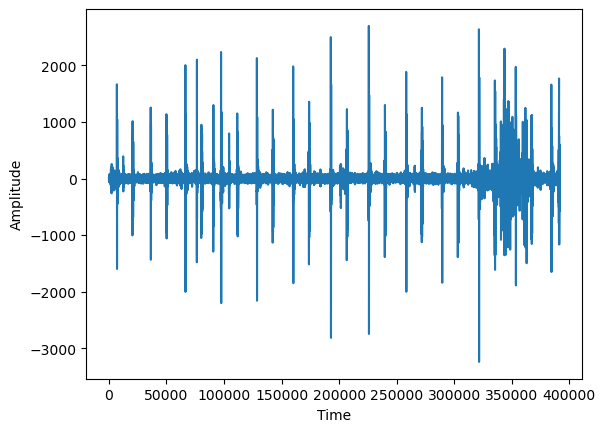

In [9]:
# We can see the waveform for a normal heartbeat has distinct patterns for the "lub-dub" the heart makes
normal_heartbeat_path = path + "/set_a/normal__201101070538.wav"
plot_waveform_for_file(normal_heartbeat_path)

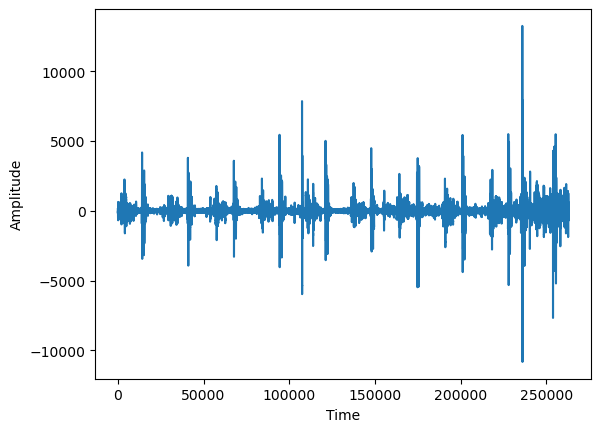

In [10]:
# We can see heartbeat murmurs begin to lose this distinct "lub-dub" pattern
murmur_heartbeat_path = path + "/set_a/murmur__201106141148.wav"
plot_waveform_for_file(murmur_heartbeat_path)

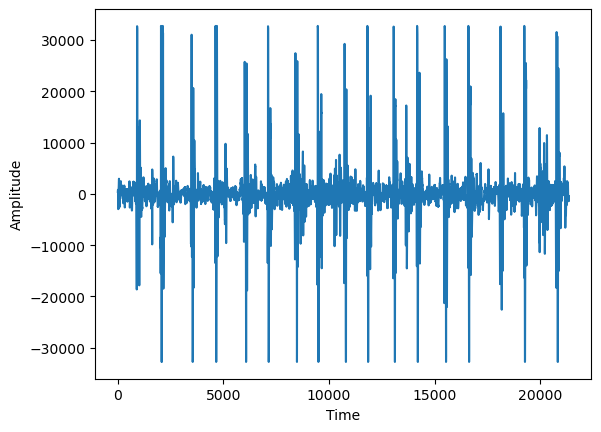

In [11]:
# Extrasystole heartbeats are out of rythm, and can result in "lub-dub-dub" or "lub-lub-dub" heartbeats
extrasystole_heartbeat_path = path + "/set_b/extrastole__144_1306522408528_B.wav"
plot_waveform_for_file(extrasystole_heartbeat_path)

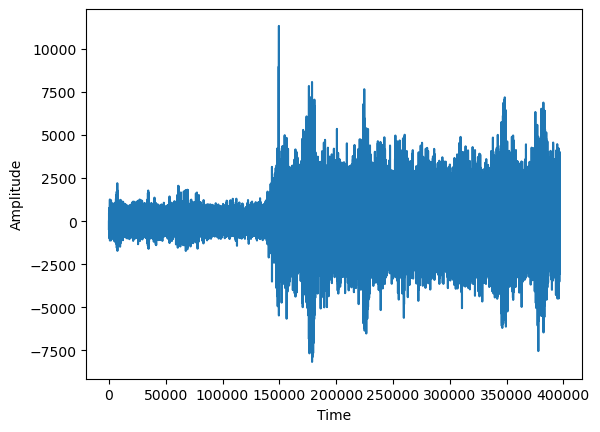

In [12]:
# Artifacts are when there aren't heartbeat sounds and needs to be
# identified so we can know when to attempt classification again
artifact_heartbeat_path = path + "/set_a/artifact__201106101314.wav"
plot_waveform_for_file(artifact_heartbeat_path)

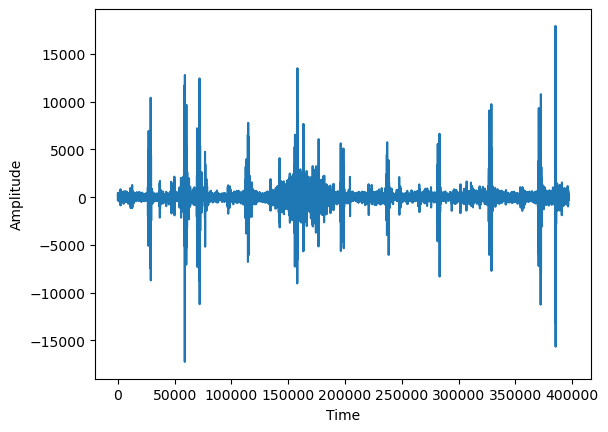

In [13]:
# The extrahls label indicates there are additional sounds with the heartbeat
extra_heart_sound_path = path + "/set_a/extrahls__201103150114.wav"
plot_waveform_for_file(extra_heart_sound_path)

<h2>Logarithmically Scaled Mel Spectrogram</h2>

In [14]:
import librosa
import librosa.display

def display_log_scaled_mel_spectrogram(file_path, title="Mel Spectrogram"):
    audio_time_series, sampling_rate = librosa.load(file_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_time_series, sr=sampling_rate)
    log_scaled_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    librosa.display.specshow(log_scaled_mel_spectrogram, y_axis='log', x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.show()

C:\Users\Syed\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


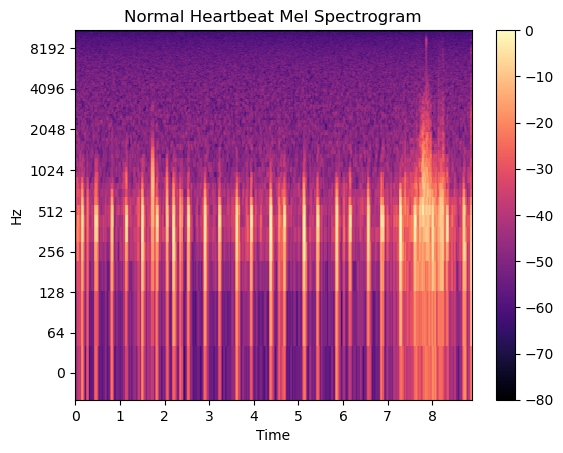

In [15]:
# Normal heartbeat mel spectrogram
display_log_scaled_mel_spectrogram(normal_heartbeat_path, "Normal Heartbeat Mel Spectrogram")

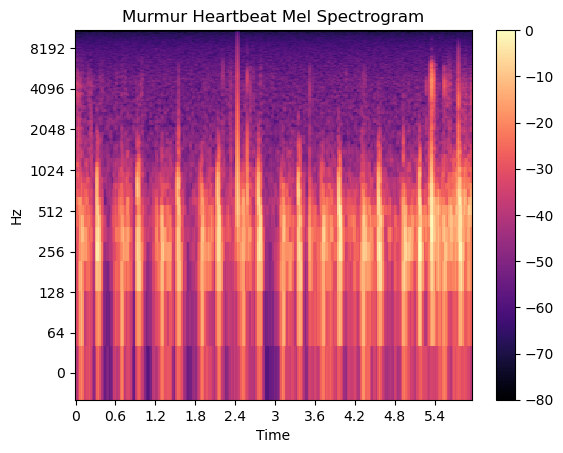

In [16]:
# Murmur heartbeat mel spectrogram
display_log_scaled_mel_spectrogram(murmur_heartbeat_path, title="Murmur Heartbeat Mel Spectrogram")

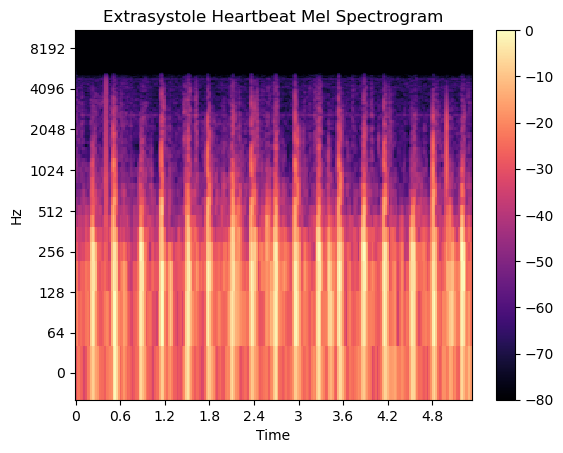

In [17]:
# Extrasystole heartbeat mel spectrogram
display_log_scaled_mel_spectrogram(extrasystole_heartbeat_path, title="Extrasystole Heartbeat Mel Spectrogram")

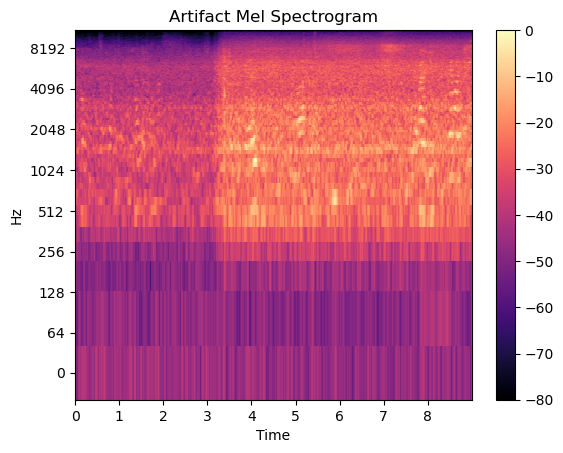

In [18]:
# Artifact mel spectrogram
display_log_scaled_mel_spectrogram(artifact_heartbeat_path, title="Artifact Mel Spectrogram")

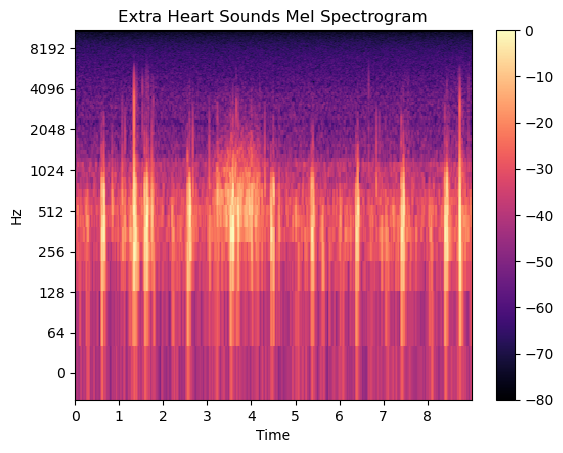

In [19]:
# Extra heart sounds mel spectrogram
display_log_scaled_mel_spectrogram(extra_heart_sound_path, title="Extra Heart Sounds Mel Spectrogram")

<h2>Audio Data Preprocessing and Feature Extraction</h2>

In [20]:
# Create our dataset
from os import walk

file_labels = []
def get_data_for_directory(directory):
    for (dirpath, dirnames, files) in walk(directory):
        for file in files:
            complete_file_path = f"{dirpath}/{file}"
            
            # Limit files to those greater than 3 seconds
            if librosa.get_duration(filename=complete_file_path) >= 3:
                label = os.path.basename(file).split("_")[0]

                # Skip our unlabelled files
                if not "unlabelledtest" in label.lower():
                    data = {
                        'label': label,
                        'file': complete_file_path,
                    }
                    file_labels.append(data)
            
get_data_for_directory(path + '/set_a')
get_data_for_directory(path + '/set_b')

dataset = pd.DataFrame(file_labels)
dataset

,label,file
0,artifact,./heartbeat_dataset/set_a/artifact__2010121720...
1,artifact,./heartbeat_dataset/set_a/artifact__2011050409...
2,artifact,./heartbeat_dataset/set_a/artifact__2011050419...
3,artifact,./heartbeat_dataset/set_a/artifact__2011050510...
4,artifact,./heartbeat_dataset/set_a/artifact__2011050601...
...,...,...
457,normal,./heartbeat_dataset/set_b/normal__294_13116810...
458,normal,./heartbeat_dataset/set_b/normal__294_13116810...
459,normal,./heartbeat_dataset/set_b/normal__298_13116858...
460,normal,./heartbeat_dataset/set_b/normal__299_13117705...


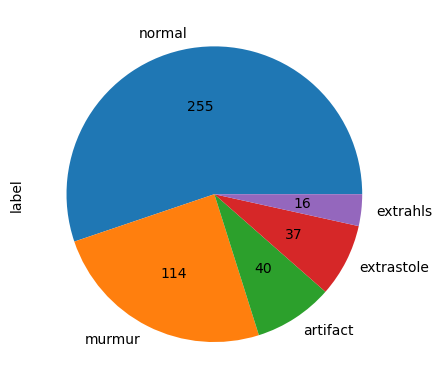

In [21]:
def absolute_value(val):
    a = np.round(val/100.*dataset.label.value_counts().sum(), 0)
    return int(a)

dataset.label.value_counts().plot(kind='pie', autopct=absolute_value)
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

# Split data to use 80% for training and 20% for testing
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(train)}")
print(f"Number of testing samples: {len(test)}")

Number of training samples: 369
Number of testing samples: 93


In [23]:
def get_melspectrogram_feature(file_path, max_pad_len=431):
    audio_time_series, sampling_rate = librosa.load(file_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_time_series, sr=sampling_rate)
    log_scaled_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding if the mel_spectrogram is shorter than max_pad_len
    pad_width = max_pad_len - log_scaled_mel_spectrogram.shape[1]
    if pad_width > 0:
        log_scaled_mel_spectrogram = np.pad(log_scaled_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Truncating if the mel_spectrogram is longer than max_pad_len
    log_scaled_mel_spectrogram = log_scaled_mel_spectrogram[:, :max_pad_len]
    
    return log_scaled_mel_spectrogram

In [24]:
x_train = []
x_test = []

def extract_features(features_array, input_array):
    for i in range(len(input_array)):
        features_array.append(
            get_melspectrogram_feature(input_array.file.iloc[i])
        )

print("Extracting training features...")
extract_features(x_train, train)
print("Training feature extraction complete")
print("Extracting test features...")
extract_features(x_test, test)
print("Test feature extraction complete")
        
# Convert lists to np array
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
print(f"Training shape: {x_train.shape}\nTesting shape: {x_test.shape}")

Extracting training features...
Training feature extraction complete
Extracting test features...
Test feature extraction complete
Training shape: (369, 128, 431)
Testing shape: (93, 128, 431)


In [25]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# train and test labels are pandas Series objects, we need to use .values to ensure
# we're working with a 1d array
encoder.fit(train.label.values)

y_train = encoder.transform(train.label.values)
y_test = encoder.transform(test.label.values)

In [26]:
from sklearn.utils import class_weight

classes = np.unique(y_train).tolist()
print("Classes: ", classes)

computed_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
print("Computed class weights: ", computed_class_weights)

class_weights = {}
for i in range(len(classes)):
    class_weights[classes[i]] = computed_class_weights[i]

class_weights

Classes:  [0, 1, 2, 3, 4]
Computed class weights:  [2.54482759 5.67692308 2.54482759 0.83863636 0.35142857]


{0: 2.5448275862068965,
 1: 5.676923076923077,
 2: 2.5448275862068965,
 3: 0.8386363636363636,
 4: 0.3514285714285714}

In [27]:
from keras.utils import to_categorical

# Shape our training data
x_train = x_train.reshape(
    x_train.shape[0],
    x_train.shape[1],
    x_train.shape[2],
    1,
)
y_train = to_categorical(
    y_train,
    num_classes=5,
)

# Shape our testing data
x_test = x_test.reshape(
    x_test.shape[0],
    x_test.shape[1],
    x_test.shape[2],
    1,
)
y_test = to_categorical(
    y_test,
    num_classes=5,
)

# y_train_one_hot = to_categorical(y_train, num_classes=5)
# y_test_one_hot = to_categorical(y_test, num_classes=5)

In [28]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Scale each feature
for i in range(x_train.shape[2]):
    # Normalize - adjusting the scale of your data so that the range is between 0 and 1.
    scaler = MinMaxScaler()
    # We temporarily reshape to 2D to scale across time steps for each feature.
    x_train[:,:,i,0] = scaler.fit_transform(x_train[:,:,i,0])
    x_test[:,:,i,0] = scaler.transform(x_test[:,:,i,0])
    
#     # Standardize - scale data so that it has a mean of 0 and a standard deviation of 1
#     scaler = StandardScaler()
#     x_train[:,:,i,0] = scaler.fit_transform(x_train[:,:,i,0])
#     x_test[:,:,i,0] = scaler.transform(x_test[:,:,i,0])

<h3>Creating Convolutional Neural Network and Long Short-Term Memory Models</h3>

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

def create_cnn():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    model.add(Dense(128, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

from keras.layers import Bidirectional, LSTM, GaussianNoise
from keras import regularizers

def create_lstm():
    input_shape = (x_train.shape[1], x_train.shape[2])  # (time_steps, features)
    
    model = Sequential()
    model.add(Bidirectional(
        LSTM(
            64,
            dropout=0.1,
            recurrent_dropout=0.1,
            return_sequences=True, kernel_regularizer=regularizers.l2(0.01)
        ), 
        input_shape=input_shape,
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))
    
    return model

model_type = "cnn"
model = create_cnn() if model_type == "cnn" else create_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 215, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 63, 215, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 107, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 105, 32)       9248      
                                                                 
 batch_normalization_1 (Bat  (None, 29, 105, 32)       128       
 chNormalization)                                                
                                                        

In [30]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Define initial learning rate
initial_learning_rate = 0.005

# Define the learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 100:
        return 0.001
    else:
        return 0.0001

# Create the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer=optimizer)

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Create the reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

<h3>Training and Evaluating the Model</h3>

In [31]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=250,
    callbacks=[early_stopping, reduce_lr],
    validation_data=(x_test, y_test),
    class_weight=class_weights,
    shuffle=True
)

Epoch 1/250
12/12 [==============================] - 4s 244ms/step - loss: 22.7813 - accuracy: 0.2954 - val_loss: 2.1638 - val_accuracy: 0.1613 - lr: 0.0050
Epoch 2/250
12/12 [==============================] - 3s 221ms/step - loss: 12.3311 - accuracy: 0.3469 - val_loss: 4.2971 - val_accuracy: 0.1828 - lr: 0.0050
Epoch 3/250
12/12 [==============================] - 3s 210ms/step - loss: 4.5196 - accuracy: 0.4526 - val_loss: 9.3602 - val_accuracy: 0.0968 - lr: 0.0050
Epoch 4/250
12/12 [==============================] - 3s 210ms/step - loss: 4.8733 - accuracy: 0.4444 - val_loss: 13.0004 - val_accuracy: 0.1075 - lr: 0.0050
Epoch 5/250
12/12 [==============================] - 3s 210ms/step - loss: 5.3086 - accuracy: 0.4499 - val_loss: 14.1286 - val_accuracy: 0.1183 - lr: 0.0050
Epoch 6/250
12/12 [==============================] - 3s 230ms/step - loss: 4.6156 - accuracy: 0.4770 - val_loss: 14.0642 - val_accuracy: 0.0753 - lr: 0.0050
Epoch 7/250
12/12 [==============================] - 3s 229

12/12 [==============================] - 3s 222ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 1.6173 - val_accuracy: 0.6667 - lr: 0.0025
Epoch 54/250
12/12 [==============================] - 3s 230ms/step - loss: 0.0128 - accuracy: 0.9892 - val_loss: 1.8320 - val_accuracy: 0.6344 - lr: 0.0025
Epoch 55/250
12/12 [==============================] - 3s 217ms/step - loss: 0.0108 - accuracy: 0.9946 - val_loss: 1.7719 - val_accuracy: 0.6774 - lr: 0.0025
Epoch 56/250
12/12 [==============================] - 3s 221ms/step - loss: 0.0086 - accuracy: 0.9946 - val_loss: 1.7634 - val_accuracy: 0.6989 - lr: 0.0025
Epoch 57/250
12/12 [==============================] - 3s 225ms/step - loss: 0.0177 - accuracy: 0.9919 - val_loss: 1.7752 - val_accuracy: 0.6452 - lr: 0.0025
Epoch 58/250
12/12 [==============================] - 3s 229ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.8317 - val_accuracy: 0.6452 - lr: 0.0025
Epoch 59/250
12/12 [==============================] - 3s 237ms/step - l

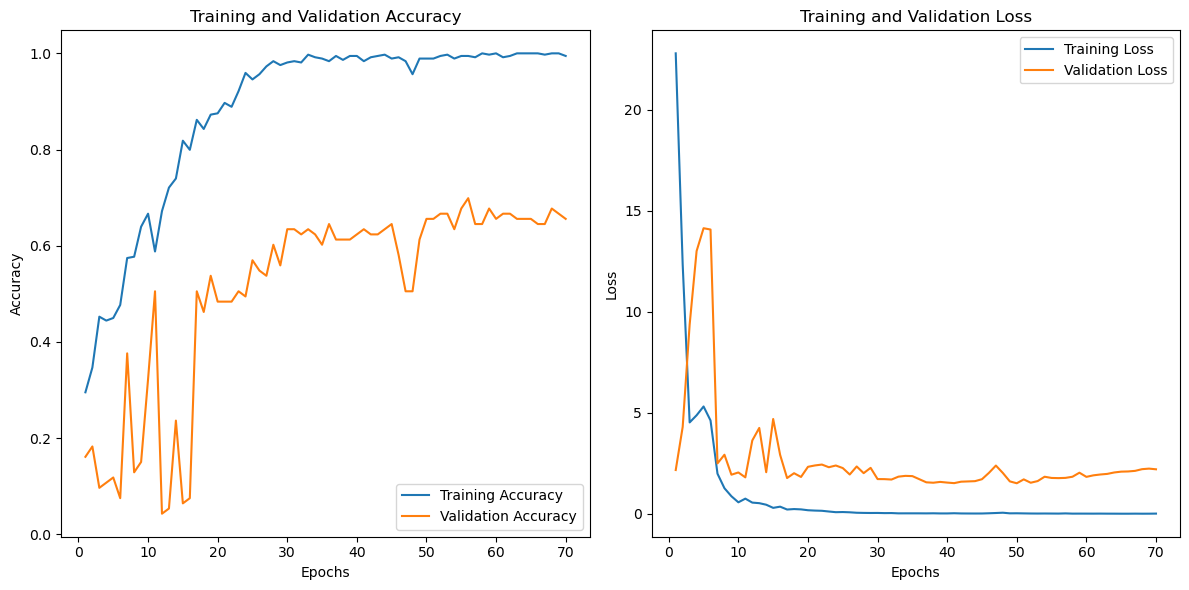

In [32]:
# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

_epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(_epochs, acc, label='Training Accuracy')
plt.plot(_epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(_epochs, loss, label='Training Loss')
plt.plot(_epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Save the model and the weights
# model.save(f"heartbeat_disease_{model_type}.keras")

In [34]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3/3 [==============================] - 0s 51ms/step - loss: 1.5088 - accuracy: 0.6559
Test loss: 1.5088458061218262
Test accuracy: 0.6559139490127563


3/3 [==============================] - 1s 62ms/step


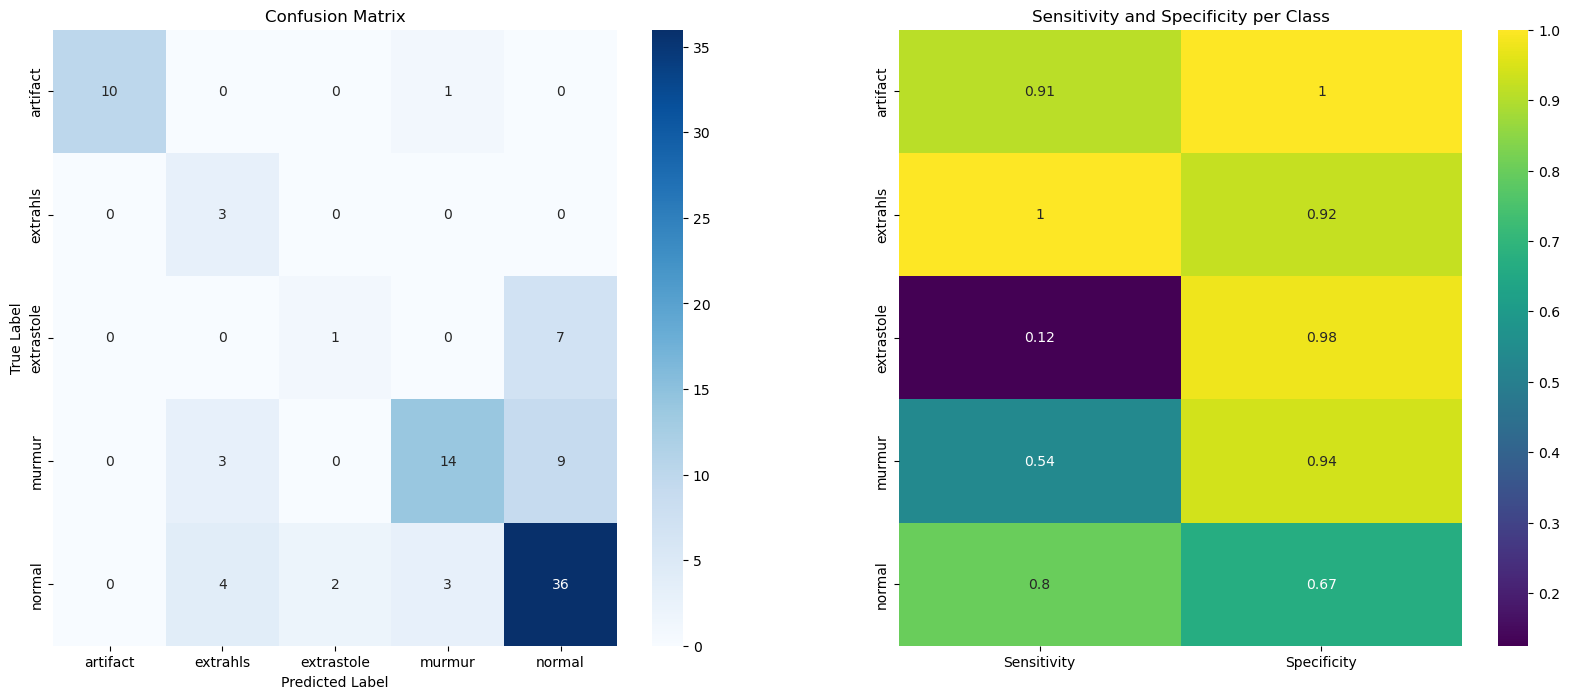

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.saving import load_model

model = load_model("./heartbeat_disease_lstm.keras")

# Predict classes
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Convert numeric labels back to original category names
y_pred_labels = encoder.inverse_transform(y_pred_classes)
y_true_labels = encoder.inverse_transform(y_true_classes)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Calculate Sensitivity and Specificity
TP = np.diag(cm)  # True Positives are on the diagonal
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (TP + FP + FN)  # True Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_, ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

# Sensitivity and Specificity
metrics_df = pd.DataFrame({'Sensitivity': sensitivity, 'Specificity': specificity}, index=encoder.classes_)
sns.heatmap(metrics_df, annot=True, cmap='viridis', ax=ax[1])
ax[1].set_title('Sensitivity and Specificity per Class')

plt.show()

3/3 [==============================] - 0s 50ms/step


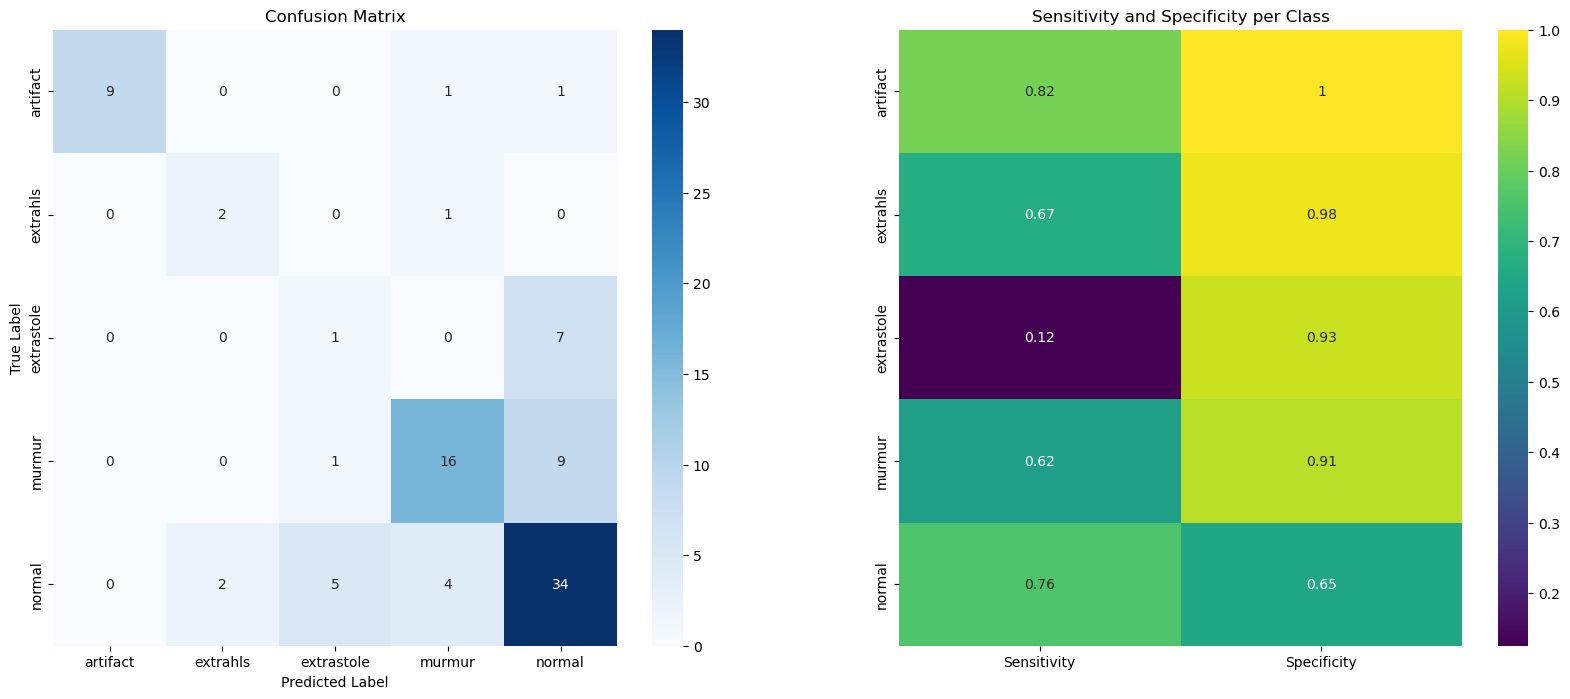

In [38]:
model = load_model("./heartbeat_disease_cnn.keras")

# Predict classes
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Convert numeric labels back to original category names
y_pred_labels = encoder.inverse_transform(y_pred_classes)
y_true_labels = encoder.inverse_transform(y_true_classes)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Calculate Sensitivity and Specificity
TP = np.diag(cm)  # True Positives are on the diagonal
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (TP + FP + FN)  # True Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_, ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

# Sensitivity and Specificity
metrics_df = pd.DataFrame({'Sensitivity': sensitivity, 'Specificity': specificity}, index=encoder.classes_)
sns.heatmap(metrics_df, annot=True, cmap='viridis', ax=ax[1])
ax[1].set_title('Sensitivity and Specificity per Class')

plt.show()